# ML Final Project

### Tanay, Vishal, Nikshita, Garv

## About the Dataset

Link to the dataset: [Link](https://www.kaggle.com/competitions/spaceship-titanic/overview)

The machine learning problem that we are trying to solve is to predict whether a passanger aboard the Spaceship Titanic was transported to an alternate dimension during its collision with a spacetime anaomaly. This can be described as a binary classification probelm with the target variable "Transported" indicating True or False. This problem matters because by coming up with an optimal solution will help provide insight on improving the safety engineering features of future space voyages, thus reducing the risks of space travel. The results of our predicitive model could be used to further enhance safety measures and improve risk management. Being able to help the goal of designing more efficient and reliable space travel methods. By predicting the transported variable we can help identify the potential causes and thus make targeted adjustments in ship design and passenger safety.

### Description of the Dataset and Attributes
`PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

`HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.

`CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

`Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

`Destination` - The planet the passenger will be debarking to.

`Age` - The age of the passenger.

`VIP` - Whether the passenger has paid for special VIP service during the voyage.

`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

`Name` - The first and last names of the passenger.

`Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [2]:
# !pip install scikit-learn matplotlib numpy pandas tensorflow

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 
from pandas import DataFrame
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

df = pd.read_csv("train.csv")

# Data Exploration

In [6]:
# Checking how many NaNs there are 
rows_with_nan = df.isnull().any(axis=1).sum()
rows_without_nan = len(df) - rows_with_nan

print(f"Rows with NaN: {rows_with_nan}")
print(f"Rows without NaN: {rows_without_nan}")

print("Columns with NaNs: ", df.isnull().any())

# Checking what the data looks like
print()
print("We can see what the data looks like for the first 5 rows.")
df.head()

Rows with NaN: 2087
Rows without NaN: 6606
Columns with NaNs:  PassengerId     False
HomePlanet       True
CryoSleep        True
Cabin            True
Destination      True
Age              True
VIP              True
RoomService      True
FoodCourt        True
ShoppingMall     True
Spa              True
VRDeck           True
Name             True
Transported     False
dtype: bool

We can see what the data looks like for the first 5 rows.


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


These columns had some sort of missing data. Because of that, we're plotting the distributions of the variables 
to see if we should impute the mean or median.


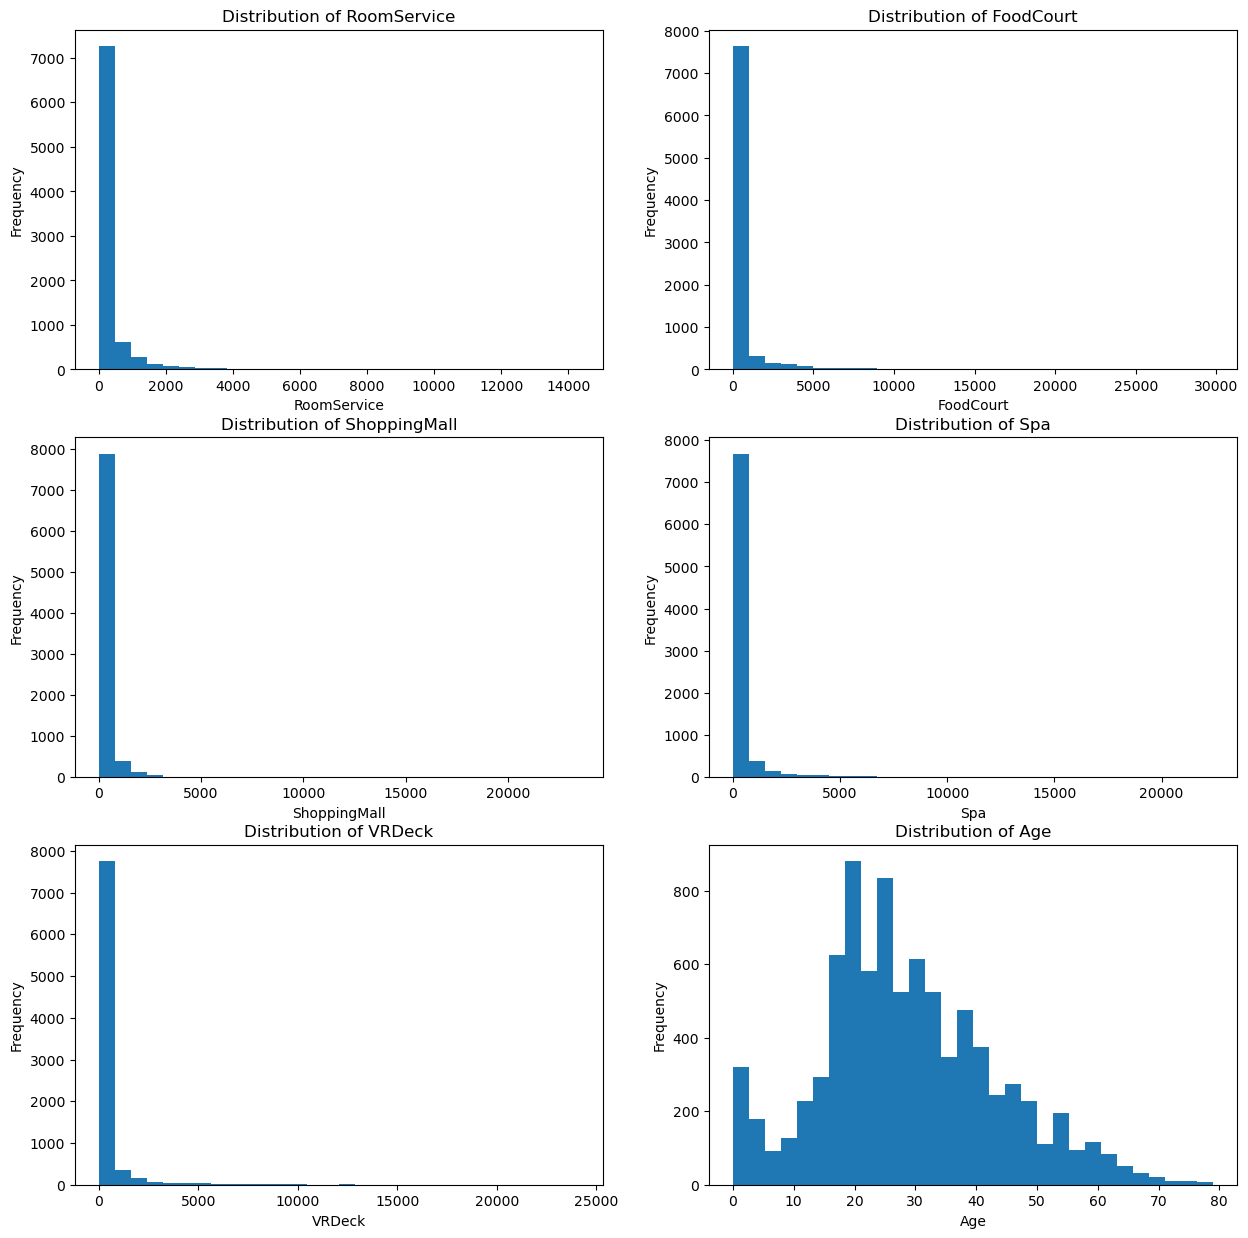

Through these graphs, we see that a lot of the distributions are right-skewed. Since there are a lot of outliers, 
we will impute the median for these variables as that will tend to be more robust to outliers.


In [9]:
# This is to see the distributions of the variables we want to impute (mean or median)
print("These columns had some sort of missing data. Because of that, we're plotting the distributions of the variables \nto see if we should impute the mean or median.")
variables = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age']

# Configure subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

# Create histograms for each variable
for i, var in enumerate(variables):
    axes[i].hist(df[var].dropna(), bins=30)
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.show()

print("Through these graphs, we see that a lot of the distributions are right-skewed. Since there are a lot of outliers, \nwe will impute the median for these variables as that will tend to be more robust to outliers.")

# Data Cleaning

Rationale: Based on the results of our data exploration, we have decided to process the data in the following ways: Initially, we planned on dropping all 2087 records with NaNs, but we later revisited this as the accuracies we were getting from our models was not as high as we thought it could be, and we felt that more data could help with this. Thus, we decided to impute numerical features with the mean for the feature, and categorical features with the the value that best fits the probability distribution. We did not impute binary features as we felt that since there were only 2 possible values, imputation was risky and could drastically impact the output if the value was off. 

In the end, we dropped 786 records with NaNs, leaving 7907 records left. We will one hot encode the HomePlanet and Destination fields as they are categorical. We will drop the Name field since it is unique (or near unique) for each passenger, and it seems unlikely it could provide useful information. As the Cabin field essentially has three pieces of information (deck, number, and side), we have elected to break it down into three fields. Similarly, as the Passenger_Id field has two pieces of information (group number and passenger number), we will break it down into two fields. We will one hot encode the deck as it has only a handful of options. We will convert the new side feature from P or S into True or False. For all numeric features (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck Age, Room, Group, PassengerNumber), we will standardize the values so that  we can conduct PCA. Lastly, we will conduct PCA on the data.

In [4]:
imputed_df = df.copy()

print("Columns with NaNs before imputation: ", imputed_df.columns[imputed_df.isnull().any()].tolist())

# fill NaNs in HomePlanet with random values based on distribution
value_counts = imputed_df['HomePlanet'].value_counts(normalize=True)
imputed_df["HomePlanet"] = imputed_df["HomePlanet"].fillna(imputed_df["HomePlanet"].apply(lambda _: np.random.choice(value_counts.index, p=value_counts.values)))

# fill NaNs in Destination with random values based on distribution
value_counts = imputed_df['Destination'].value_counts(normalize=True)
imputed_df["Destination"] = imputed_df["Destination"].fillna(imputed_df["Destination"].apply(lambda _: np.random.choice(value_counts.index, p=value_counts.values)))

# Impute RoomService with the mean
imputed_df["RoomService"] = imputed_df["RoomService"].fillna(imputed_df["RoomService"].median())

# Impute FoodCourt with the mean
imputed_df["FoodCourt"] = imputed_df["FoodCourt"].fillna(imputed_df["FoodCourt"].median())

# Impute ShoppingMall with the mean
imputed_df["ShoppingMall"] = imputed_df["ShoppingMall"].fillna(imputed_df["ShoppingMall"].median())

# Impute Spa with the mean
imputed_df["Spa"] = imputed_df["Spa"].fillna(imputed_df["Spa"].median())

# Impute VRDeck with the mean
imputed_df["VRDeck"] = imputed_df["VRDeck"].fillna(imputed_df["VRDeck"].median())

# Impute Age with the mean
imputed_df['Age'] = imputed_df['Age'].fillna(imputed_df['Age'].mean())

# drop NaNs
processed_features = imputed_df.dropna()

# Drop Name values
imputed_df = imputed_df.drop(columns=['Name'])

print("Columns with NaNs after imputation: ", imputed_df.columns[imputed_df.isnull().any()].tolist())

Columns with NaNs before imputation:  ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']
Columns with NaNs after imputation:  ['CryoSleep', 'Cabin', 'VIP']


In [5]:
processed_df = imputed_df.copy()

# Split Cabin values into three columns
processed_df[["Deck", "Room", "Side"]] = processed_df['Cabin'].str.split("/", expand=True)
processed_df = processed_df.drop(columns=['Cabin'])

# Split Passenger values into two columns
processed_df[["Group", "Passenger_Number"]] = processed_df['PassengerId'].str.split("_", expand=True)
processed_df = processed_df.drop(columns=['PassengerId'])

# One hot encode the HomePlanet
processed_df = pd.get_dummies(processed_df, columns=["HomePlanet"])

# One hot encode the DestinationPlanet
processed_df = pd.get_dummies(processed_df, columns=["Destination"])

# One hot encode the Deck
processed_df = pd.get_dummies(processed_df, columns=["Deck"])

# convert Side to T or F
processed_df["Side"] = processed_df['Side'].map({'P': True, 'S' : False})

# normalizing numeric features
scaler = StandardScaler()
processed_df['RoomService'] = scaler.fit_transform(processed_df[['RoomService']])
processed_df['FoodCourt'] = scaler.fit_transform(processed_df[['FoodCourt']])
processed_df['ShoppingMall'] = scaler.fit_transform(processed_df[['ShoppingMall']])
processed_df['Spa'] = scaler.fit_transform(processed_df[['Spa']])
processed_df['VRDeck'] = scaler.fit_transform(processed_df[['VRDeck']])
processed_df['Age'] = scaler.fit_transform(processed_df[['Age']])
processed_df['Group'] = scaler.fit_transform(processed_df[['Group']])
processed_df['Passenger_Number'] = scaler.fit_transform(processed_df[['Passenger_Number']])

rows_with_nan = processed_df.isnull().any(axis=1).sum()
rows_without_nan = len(processed_df) - rows_with_nan

print(f"Rows with NaN (will be dropped): {rows_with_nan}")
print(f"Rows without NaN: {len(processed_df) - rows_with_nan}")

processed_df = processed_df.dropna()

processed_features.head()

Rows with NaN (will be dropped): 599
Rows without NaN: 8094


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
labels = processed_df["Transported"]
processed_features = processed_df.drop(labels = "Transported", axis="columns")

pca = PCA(svd_solver='full')
pca_data = pca.fit_transform(processed_features)
pca_df = DataFrame(pca_data)

print("Original data shape:", processed_features.shape)
print("Transformed data shape:", pca_df.shape)
# processed_features.head()
pca_df.shape
pca_df.head()

Original data shape: (8094, 26)
Transformed data shape: (8094, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-599.080833,-0.486637,0.470068,-0.805787,-0.174749,-0.182076,0.323537,-0.114714,-0.464225,-0.469705,0.061856,0.515138,0.030010,-0.878143,-0.170236,-0.255589,0.845632,0.676824,0.034620,-0.162650
1,-599.079417,-0.979077,0.276521,-0.410011,-0.251974,-0.201461,-0.899259,-0.185833,-0.971601,-0.386929,0.165093,-0.530277,-0.587615,-0.276607,0.132727,0.096496,-0.101492,-0.381250,-0.100874,-0.014465
2,-599.083470,3.939557,0.160881,-0.662833,0.410594,-4.110085,-1.716074,-0.905434,-1.432550,-0.166612,0.261151,-0.459390,0.595623,-0.086059,-0.046464,-0.122794,0.133690,0.265891,0.305605,1.106527
3,-599.081836,1.209923,-0.218519,0.624514,0.007044,-1.915883,-0.928460,-0.720860,-0.882651,-0.361803,0.180074,-0.485048,0.260586,-0.398297,-0.067447,-0.288711,0.141707,0.430861,0.325552,0.985960
4,-598.079285,-1.141752,0.301198,-0.020875,-0.196227,-0.059265,-1.335536,-0.036497,-0.821753,-0.362027,0.145245,-0.536861,-0.543292,-0.330202,0.160781,0.125386,-0.115021,-0.378990,-0.092417,-0.008300


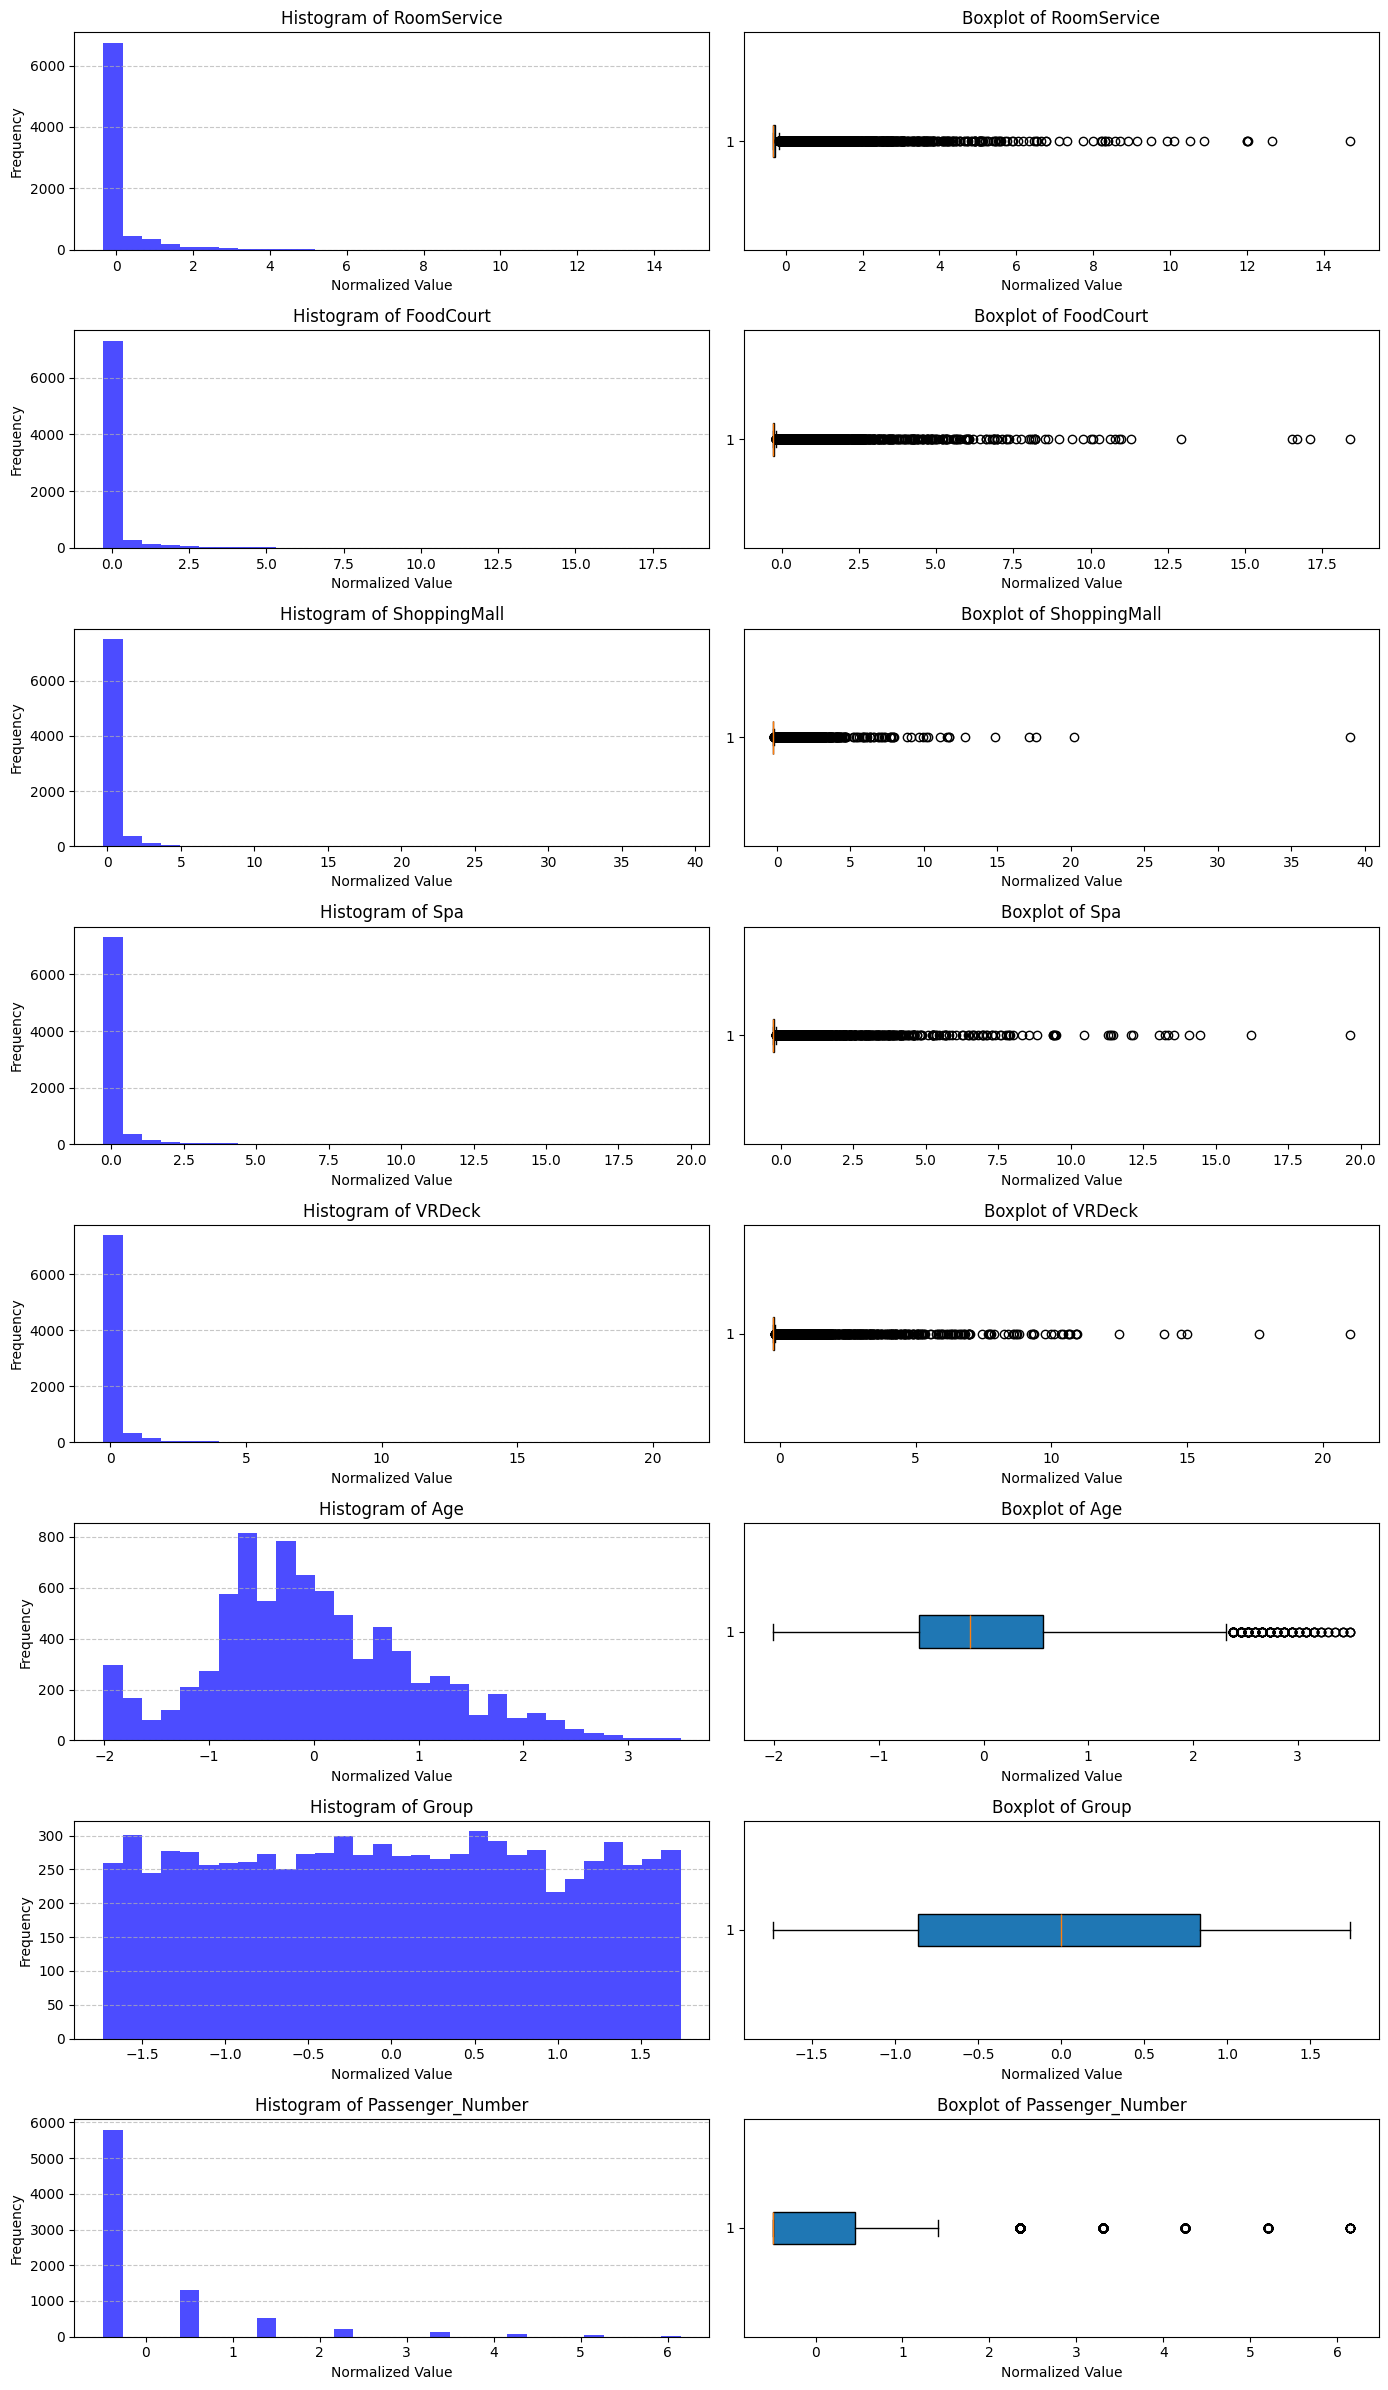

In [7]:
# List of features to plot
features_to_plot = [
    'RoomService', 'FoodCourt', 'ShoppingMall', 
    'Spa', 'VRDeck', 'Age', 
    'Group', 'Passenger_Number'
]

# Create subplots for histograms and boxplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(14, 24))  # 8 rows, 2 columns
axes = axes.flatten()  # Flatten axes for easier iteration

# Plot both histograms and boxplots
for i, feature in enumerate(features_to_plot):
    # Plot histogram
    axes[2 * i].hist(processed_features[feature], bins=30, color='blue', alpha=0.7)
    axes[2 * i].set_title(f"Histogram of {feature}")
    axes[2 * i].set_xlabel("Normalized Value")
    axes[2 * i].set_ylabel("Frequency")
    axes[2 * i].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot boxplot
    axes[2 * i + 1].boxplot(processed_features[feature], vert=False, patch_artist=True)
    axes[2 * i + 1].set_title(f"Boxplot of {feature}")
    axes[2 * i + 1].set_xlabel("Normalized Value")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


[Text(0, 0.5, 'HomePlanet_Europa'),
 Text(0, 1.5, 'HomePlanet_Earth'),
 Text(0, 2.5, 'Room'),
 Text(0, 3.5, 'Deck_G'),
 Text(0, 4.5, 'Deck_F'),
 Text(0, 5.5, 'HomePlanet_Mars'),
 Text(0, 6.5, 'Deck_C'),
 Text(0, 7.5, 'Deck_B'),
 Text(0, 8.5, 'CryoSleep'),
 Text(0, 9.5, 'FoodCourt'),
 Text(0, 10.5, 'Destination_55 Cancri e'),
 Text(0, 11.5, 'Destination_TRAPPIST-1e'),
 Text(0, 12.5, 'Transported'),
 Text(0, 13.5, 'VRDeck'),
 Text(0, 14.5, 'Spa'),
 Text(0, 15.5, 'Destination_PSO J318.5-22'),
 Text(0, 16.5, 'Age'),
 Text(0, 17.5, 'Deck_D'),
 Text(0, 18.5, 'Deck_A'),
 Text(0, 19.5, 'RoomService'),
 Text(0, 20.5, 'Deck_E'),
 Text(0, 21.5, 'VIP'),
 Text(0, 22.5, 'Passenger_Number'),
 Text(0, 23.5, 'ShoppingMall'),
 Text(0, 24.5, 'Group'),
 Text(0, 25.5, 'Side'),
 Text(0, 26.5, 'Deck_T')]

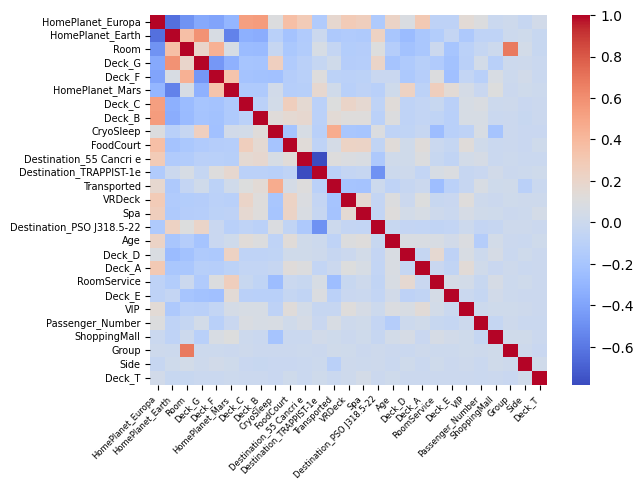

In [8]:
correlation = processed_df.corr()

sorted_indices = correlation.abs().mean().sort_values(ascending=False).index  # Sort by average absolute correlation
sorted_correlation = correlation.loc[sorted_indices, sorted_indices]

ax = sns.heatmap(sorted_correlation, fmt=".2f", cmap="coolwarm")

# Display all attributes
ax.set_xticks(np.arange(len(sorted_correlation.columns)) + 0.5, minor=False)
ax.set_yticks(np.arange(len(sorted_correlation.index)) + 0.5, minor=False)

# # Assign proper labels to all ticks
ax.set_xticklabels(sorted_correlation.columns, fontsize=6, rotation=45, ha="right")  # Rotate x-axis labels
ax.set_yticklabels(sorted_correlation.index, fontsize=7)

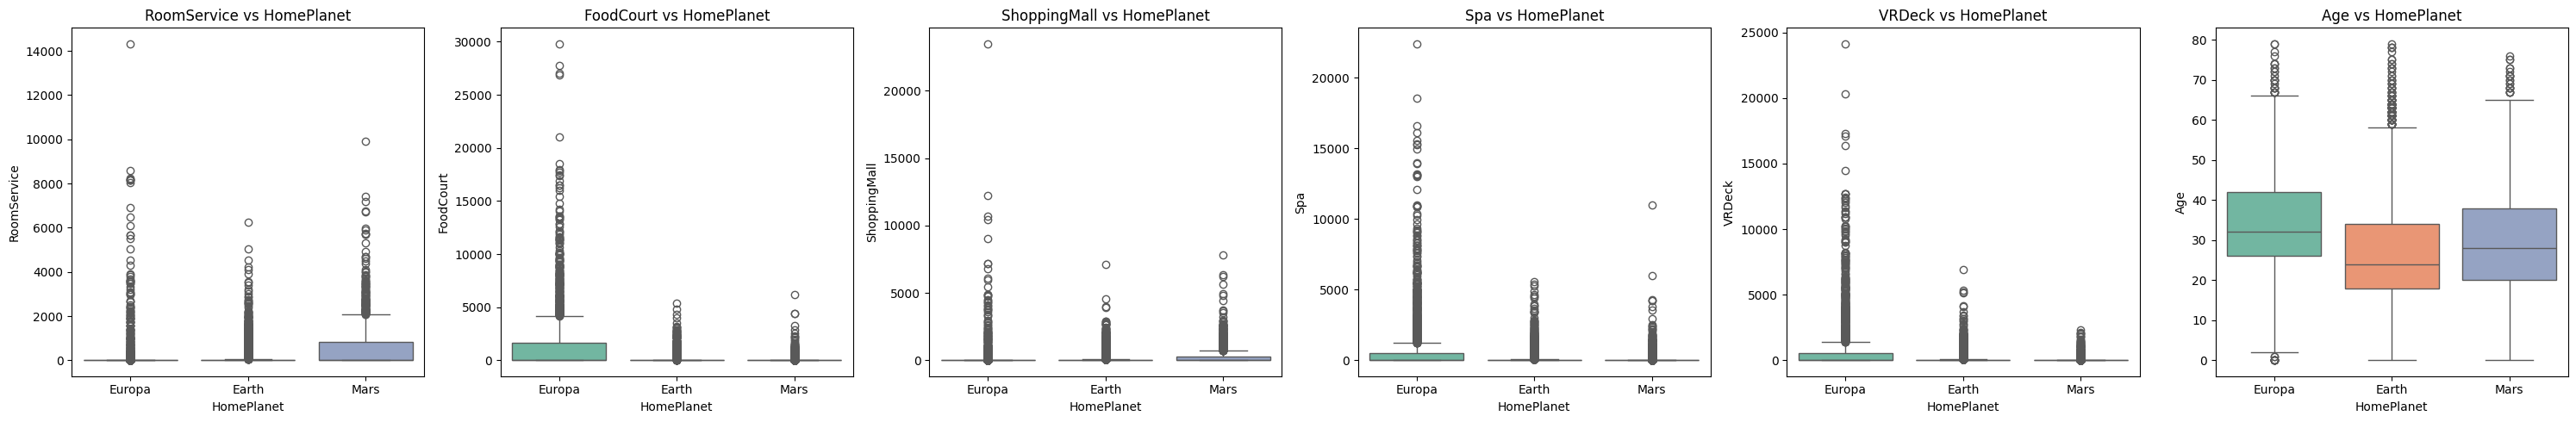

In [9]:
attributes = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Age"]
n_plots = len(attributes)

fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5), sharey=False)

for i, attribute in enumerate(attributes):
    sns.boxplot(
        data=imputed_df,
        x="HomePlanet",
        y=attribute,
        palette="Set2",
        ax=axes[i],
        hue="HomePlanet"
    )
    axes[i].set_title(f"{attribute} vs HomePlanet")
    axes[i].set_xlabel("HomePlanet")

plt.tight_layout()
plt.show()

We thought there would be a correlation between the HomePlanet and a few different attributes, but what I found that the data is all over the place. The only real outliers that I found was that Europa tended to spend a lot more on the food court and spa more.

# Model Training

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score

def fit_grid_search_cv(grid_search, features, labels_cv):
    
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(features, labels_cv, test_size=0.2)

    grid_search.fit(x_train, y_train)

    print("Best parameters found: ", grid_search.best_params_)
    print("Best score found: ", grid_search.best_score_)
    print("Best estimator found: ", grid_search.best_estimator_)
    print("Best index found: ", grid_search.best_index_)

    best_model = grid_search.best_estimator_
    accuracy = cross_val_score(best_model, x_test, y_test, cv=5, scoring="accuracy").mean()
    print("Accuracy = " ,accuracy)
    return best_model


In [11]:

from sklearn.metrics import confusion_matrix
def print_classification_statistics(best_model, processed_features, labels):
    label_preds = best_model.predict(processed_features)
    confusion_mat = confusion_matrix(labels, label_preds)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Prediced False', 'Predicted True'], yticklabels=['Acutal False', 'Actual True'])
    class_report = sklearn.metrics.classification_report(labels, label_preds)
    print(class_report)

### Decision Tree Model

- We Started off with training a decision tree classifier on the dataset. 
- Realizing we have 26 feature columns in our dataset, we decided to use PCA to reduce the dimensionality of the dataset.
- We created a pipeline with a PCA step and a decision tree classifier step which was then put into a grid search to find the best hyperparameters.
---

- We found the best PCA components to be 20. 
- The best hyperparameters for the decision tree classifier were:
    - criterion: 'gini'
    - max_depth: 15
    - min_samples_leaf: 20
    - max_features: 15
    - splitter: 'best'

- After Splitting the dataset into a training and testing set (80-20 split), we trained the model on the training set and tested it on the testing set.
- The best score of the model while training was found to be 76.5% and the cross validation accuracy on the testing set was found to be 71.9%.

/home/tanay24/miniconda3/envs/cs363m/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'clf__criterion': 'gini', 'clf__max_depth': 25, 'clf__max_features': 15, 'clf__min_samples_leaf': 30, 'pca__n_components': 15}
Best score found:  0.7655598455598456
Best estimator found:  Pipeline(steps=[('pca', PCA(n_components=15)),
                ('clf',
                 DecisionTreeClassifier(max_depth=25, max_features=15,
                                        min_samples_leaf=30))])
Best index found:  807
Accuracy =  0.7405859419791309
              precision    recall  f1-score   support

       False       0.80      0.81      0.81      4019
        True       0.81      0.80      0.81      4075

    accuracy                           0.81      8094
   macro avg       0.81      0.81      0.81      8094
weighted avg       0.81      0.81      0.81      8094



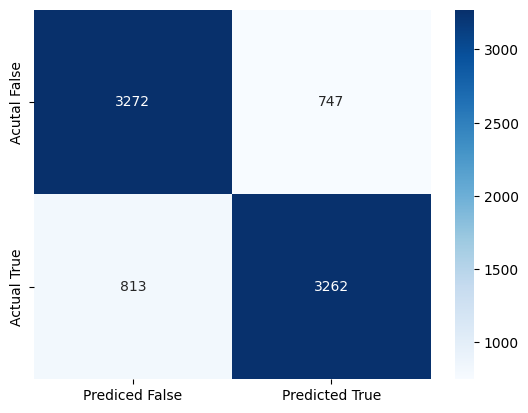

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline


clf = DecisionTreeClassifier()

# create a pipeline that first runs PCA and then the DecisionTreeClassifier
pipe = Pipeline(steps=[('pca', PCA()), ('clf', clf)])

param_grid = {
    "pca__n_components": [5, 10, 15, 20, 25],
    'clf__max_depth': [5, 10, 15, 20, 25, 30],
    'clf__min_samples_leaf': [5, 10, 15, 20, 25, 30],
    'clf__max_features': [5, 10, 15, 20, 25, 30],
    'clf__criterion': ['gini', 'entropy']
}

# runs the nested cross validation
# acc = cross_val_score(GridSearchCV(pipe, param_grid, cv=5), X=processed_features, y=labels, cv=10)
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

best_model = fit_grid_search_cv(grid_search, processed_features, labels)
print_classification_statistics(best_model, processed_features, labels)

### KNN

- Next, we trained a KNN classifier on the dataset.
- We created a pipeline with a Standard Scaler Step, a PCA step and a KNN classifier step which was then put into a grid search to find the best hyperparameters.
---

- We found the best PCA components to be 21.
- The best hyperparameters for the KNN classifier were:
    - n_neighbors: 14
    - weights: 'distance'
    - algorithm: 'auto'

/home/tanay24/miniconda3/envs/cs363m/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'knn__algorithm': 'auto', 'knn__n_neighbors': 10, 'knn__weights': 'distance', 'pca__n_components': 21}
Best score found:  0.7780694980694981
Best estimator found:  Pipeline(steps=[('std_scaler', StandardScaler()), ('pca', PCA(n_components=21)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=10, weights='distance'))])
Best index found:  136
Accuracy =  0.749839467950923
              precision    recall  f1-score   support

       False       0.95      0.96      0.96      4019
        True       0.96      0.95      0.96      4075

    accuracy                           0.96      8094
   macro avg       0.96      0.96      0.96      8094
weighted avg       0.96      0.96      0.96      8094



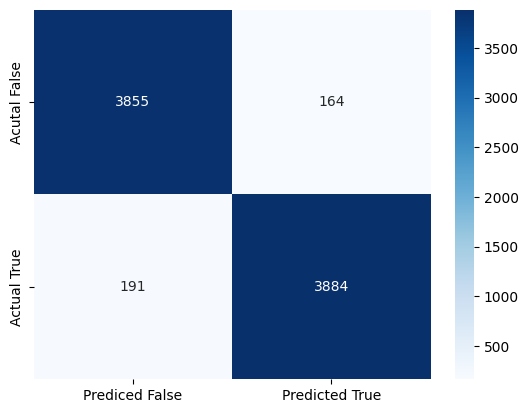

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier


std_scaler = StandardScaler()
pca = PCA()
knn = KNeighborsClassifier()

pipeline = Pipeline([
    ('std_scaler', std_scaler),
    ('pca', pca),
    ('knn', knn),
])

param_grid = {
    'pca__n_components': list(range(18, 25)),
    'knn__n_neighbors': list(range(1, 15)), 
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

inner_cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

best_model = fit_grid_search_cv(inner_cv, processed_features, labels)

print_classification_statistics(best_model, processed_features, labels)

### Support Vector Machine

Best parameters found:  {'pca__n_components': 18, 'svc__kernel': 'rbf'}
Best score found:  0.7793050193050193
Best estimator found:  Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=18)),
                ('svc', SVC())])
Best index found:  40
Accuracy =  0.7665118679050567
              precision    recall  f1-score   support

       False       0.77      0.84      0.80      4019
        True       0.83      0.75      0.79      4075

    accuracy                           0.79      8094
   macro avg       0.80      0.80      0.79      8094
weighted avg       0.80      0.79      0.79      8094



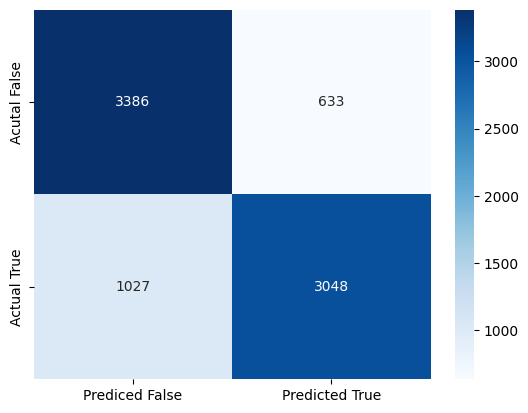

In [14]:
from sklearn.svm import SVC
import sklearn as sk

ss = StandardScaler()

pipeline = Pipeline([
    ('scaler', ss),
    ('pca', pca),
    ('svc', SVC())
])

params_grid = {
    'pca__n_components': list(range(5, 19)),
    'svc__kernel': ['linear', 'rbf', 'poly']
}

inner_cv = GridSearchCV(pipeline, params_grid, cv=5, scoring='accuracy', n_jobs=-1)
best_model = fit_grid_search_cv(inner_cv, processed_features, labels)
print_classification_statistics(best_model, processed_features, labels)

### Neural Network

Epoch 1/20


/home/tanay24/miniconda3/envs/cs363m/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5234 - loss: 12.3027
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6703 - loss: 0.7963
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7182 - loss: 0.5763
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7586 - loss: 0.5035
Epoch 5/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7459 - loss: 0.5019
Epoch 6/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7305 - loss: 0.5303
Epoch 7/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7732 - loss: 0.4616
Epoch 8/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7646 - loss: 0.4699
Epoch 9/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7692 - loss: 0.4740
Epoch 10/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7734 - loss: 0.4597
Epoch 11/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7834 - loss: 0.4322
Epoch 12/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accurac

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_71 (Dense)                │ (None, 2048)           │        43,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,724,229 (48.54 MB)

 Trainable params: 4,241,409 (16.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,482,820 (32.36 MB)

Model Summary:  None
history:  <keras.src.callbacks.history.History object at 0x7eff906bc0e0>
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


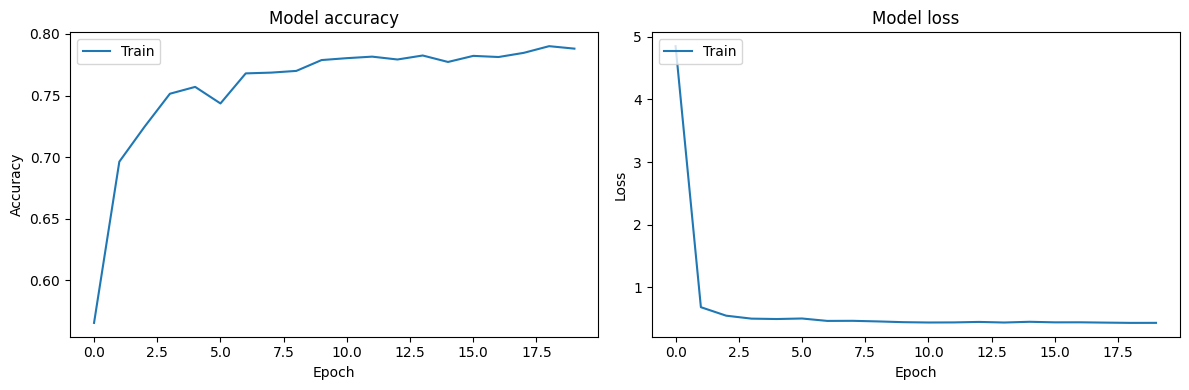

Accuracy:  0.8029647930821495


In [35]:
# Necessary Imports
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy

def plot_history(history):
    """
    Plots the training and validation loss and accuracy of a neural network model

    :param history: the history object of a trained model

    :return: None 
    """
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Train Model
X_train, X_test, y_train, y_test = train_test_split(pca_df, labels, test_size=0.2)

model = Sequential([
    Dense(2048, activation='relu', input_dim=X_train.shape[1]),
    Dense(2048, activation='relu'),
    Dropout(0.2),
    # Output layer for binary classification
    Dense(1, activation='sigmoid')  
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

y_pred = (model.predict(X_test) > 0.5).astype(int)

plot_history(history)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# print_classification_statistics(best_model, pca_df, labels)

# Random Forest

- We trained a Random Forest classifier on the dataset. Due to the large number of features, we decided to use PCA to reduce the dimensionality of the dataset.
- We chose to test the accuracy of the random forest classifier due to its ability to fit itself to the data and its ability to handle large datasets. Due to its ensemble nature, it is also able to handle overfitting better than a decision tree. We were worried about overfitting due to noticing high accuracy results in our decision tree and KNN models in the training set but lower accuracy in the testing set.
- The above assumption was reinforced when we saw an increase in accuracy when we increased the number of trees in the random forest classifier.

---

- We found the best PCA components to be 10
- The best hyperparameters for the random forest classifier were:
    - n_estimators: 150
    - criterion: 'gini'
    - max_depth: 15
    - min_samples_leaf: 5
    - min_aamples_split: 10

Best parameters found:  {'pca__n_components': 10, 'rf__max_depth': 15, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 150}
Best score found:  0.7907335907335906
Best estimator found:  Pipeline(steps=[('pca', PCA(n_components=10)),
                ('rf',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=5,
                                        min_samples_split=10,
                                        n_estimators=150))])
Best index found:  1
Accuracy =  0.7751786874593893
              precision    recall  f1-score   support

       False       0.89      0.89      0.89      4019
        True       0.89      0.89      0.89      4075

    accuracy                           0.89      8094
   macro avg       0.89      0.89      0.89      8094
weighted avg       0.89      0.89      0.89      8094



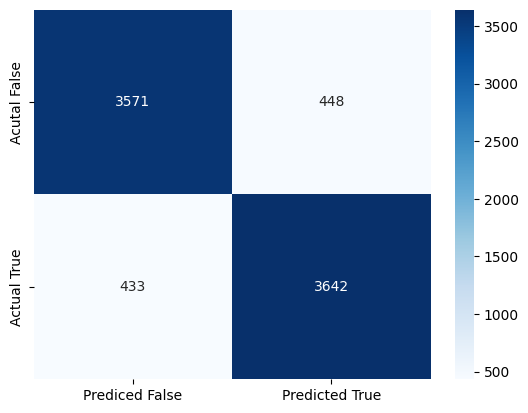

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

pca = PCA()
rf = RandomForestClassifier()

pipeline = Pipeline([
    ('pca', pca),
    ('rf', rf),
])

param_grid = {
    'pca__n_components': list(range(10, 25, 50)),
    'rf__n_estimators': list(range(100, 450, 50)),
    'rf__max_depth': list(range(15, 20, 5)),
    'rf__min_samples_split': list(range(10, 50, 10)),
    'rf__min_samples_leaf': list(range(5, 15, 5)),
}

inner_cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
best_model = fit_grid_search_cv(inner_cv, processed_features, labels)
print_classification_statistics(best_model, processed_features, labels)

### KMeans Clustering

- Reasoning and results description:
- Cluster 0: Predominantly non-transported passengers
- Cluster 1: Primarily non-transported passengers
- Low accuracy suggests the clustering does not perfectly align with the transport status.
- KMeans captures general groupings, but it doesn’t fully capture transport status, indicating other features may be influencing the clustering.
- KMeans is useful for identifying general patterns but may not be ideal for directly predicting the transport status in this case.

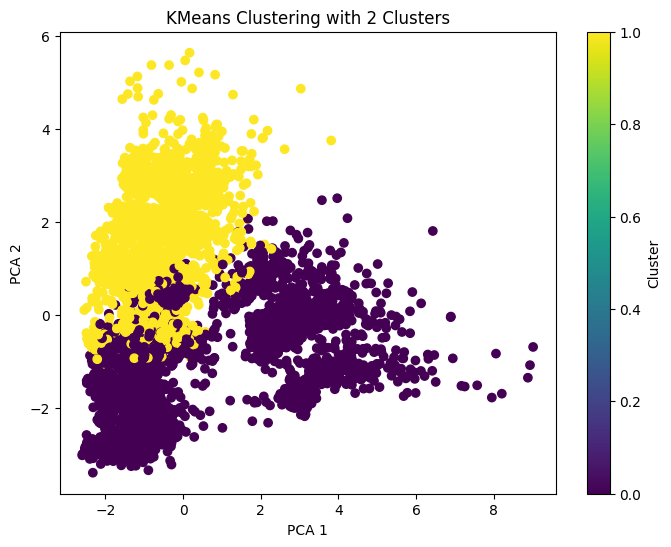

Contingency Table:
Cluster        0    1
Transported          
False        397  394
True         544  284


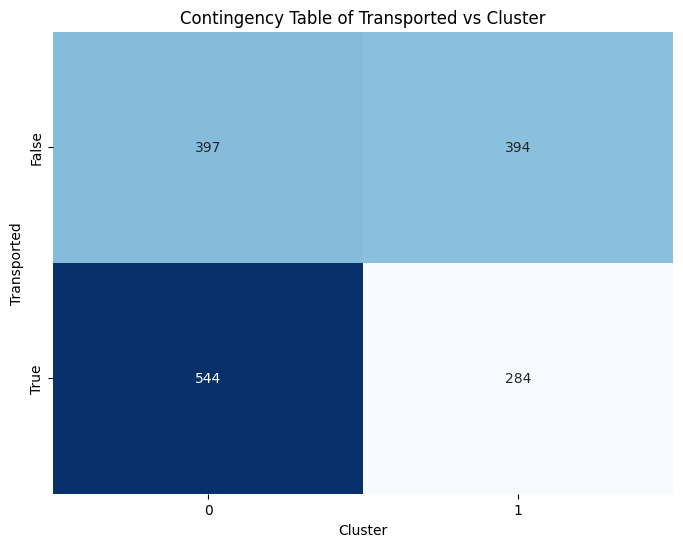

Clustering Accuracy: 0.4206
Cluster Mapping: {0: 'Not Transported', 1: 'Transported'}


/tmp/ipykernel_1599/2941919148.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy = (contingency_table[0][0] + contingency_table[1][1]) / contingency_table.sum().sum()
/tmp/ipykernel_1599/2941919148.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if contingency_table[0][0] > contingency_table[1][0]:


In [45]:
from sklearn.cluster import KMeans

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2)

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(X_train)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(features_scaled)

X_train['Cluster'] = kmeans.labels_

pca = PCA(n_components=2)
pca_data = pca.fit_transform(features_scaled)

X_train.head()

# Plot the 2D scatter plot of the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=X_train['Cluster'], cmap='viridis')
plt.title("KMeans Clustering with 2 Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()

predictions = kmeans.predict(scaler.transform(X_test))

# Create a contingency table to analyze the relationship between clusters and transport status
contingency_table = pd.crosstab(y_test, predictions, rownames=["Transported"], colnames=["Cluster"])

# Print the contingency table
print("Contingency Table:")
print(contingency_table)

# Visualize the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Contingency Table of Transported vs Cluster")
plt.xlabel("Cluster")
plt.ylabel("Transported")
plt.show()

# Calculate clustering accuracy (if clusters align well with Transported labels)
accuracy = (contingency_table[0][0] + contingency_table[1][1]) / contingency_table.sum().sum()
print(f"Clustering Accuracy: {accuracy:.4f}")

# Determine which cluster represents 'Transported' or 'Not Transported'
cluster_mapping = {}
if contingency_table[0][0] > contingency_table[1][0]:
    cluster_mapping[0] = "Not Transported"
    cluster_mapping[1] = "Transported"
else:
    cluster_mapping[0] = "Transported"
    cluster_mapping[1] = "Not Transported"

print(f"Cluster Mapping: {cluster_mapping}")